In [ ]:
!pip install -q --disable-pip-version-check -r ./requirements.txt

In [1]:
from h5py import File
import numpy as np

def load_nyu_data():
    """
    Labeled dataset available from:
        https://cs.nyu.edu/~silberman/datasets/nyu_depth_v2.html
    All features are described on that page.
    """
    with File('nyu_depth_v2_labeled.mat') as data:
        X = np.moveaxis(data['images'][:], 1, -1)
        Y = data['depths'][:][..., None]
    
    print('Full shape X/Y:', X.shape, Y.shape)
    
    # image data is 255 RGB  
    X = X.astype(float) / 255.
    
    # Create a random training / validation split
    indices   = np.arange(len(X))
    np.random.shuffle(indices)
    n_train   = int(len(X) * 0.7)
    train_idx = indices[:n_train]
    valid_idx = indices[n_train:]

    x_train = X[train_idx]
    y_train = Y[train_idx]
    x_valid = X[valid_idx]
    y_valid = Y[valid_idx]
    print('Train X/Y:', x_train.shape, y_train.shape)
    print('Valid X/Y:', x_valid.shape, y_valid.shape)
    return (x_train, y_train), (x_valid, y_valid)

(1449, 640, 480, 3) (1449, 640, 480, 1)


In [6]:
import tensorflow as tf 

def create_dataset(X, Y, patch_size, batch_size):
    """ 
    Create a tensorflow dataset object to iterate over random patches from X/Y 
    Shapes should be:
        X = (n_samples, height, width, n_features)
        Y = (n_samples, height, width, 1)
    """
    rng   = np.random.default_rng()
    image = np.append(X, Y, -1)
    
    def gen_patches():
        rng.shuffle(image, axis=0)
        for img in image:
            patch = tf.image.random_crop(img, [patch_size, patch_size, img.shape[-1]])
            patch = tf.image.random_flip_left_right(patch)
            patch = tf.image.random_flip_up_down(patch)
            yield patch[..., :X.shape[-1]], patch[..., X.shape[-1]:]
    
    signature = (
        tf.TensorSpec(shape=(patch_size, patch_size, X.shape[-1]), dtype=tf.float32), 
        tf.TensorSpec(shape=(patch_size, patch_size, Y.shape[-1]), dtype=tf.float32)
    )
    return (
        tf.data.Dataset.from_generator(gen_patches, output_signature=signature)
        .batch(batch_size)
        .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    )

In [16]:
class Model:
    """ Wraps data preprocessing/postprocessing with model interaction """
    
    def __init__(self, network):
        self.network = network
        
        
    def fit(self, X, Y, patch_size, batch_size, **kwargs):
        """ Fit model to the given data """
        # Calculate constants for standardization
        self.x_mean = np.mean(x_train)
        self.x_std  = np.std(x_train)
        self.y_mean = np.mean(y_train)
        self.y_std  = np.std(y_train)

        X, Y = self.preprocess(X, Y)
        data = create_dataset(X, Y, patch_size, batch_size)
        return self.network.fit(data, **kwargs)
    
    
    def predict(self, X):
        """ Make a prediction for the given data """
        X = self.preprocess(X)
        Z = self.network.predict(X)
        return self.postprocess(Z)
    
    
    def preprocess(self, X, Y=None):
        """ Standardize input / target data to 0 mean / 1 stdev """
        X = (X - self.x_mean) / self.x_std
        if Y is None: return X
        Y = (Y - self.y_mean) / self.y_std
        return X, Y
    
    
    def postprocess(self, Z):
        """ Reproject the estimate back into the original target domain """
        return Z * self.y_std + self.y_mean
    

In [7]:
from models.UNet import create_unet
kwargs = {
    'patch_size' : 224,
    'batch_size' : 16,
    'epochs'     : 2000,
    'verbose'    : 1,
}

training, (x_valid, y_valid) = load_nyu_data()

network   = create_unet(kwargs['patch_size'], x_valid.shape[-1])
optimizer = tf.optimizers.SGD(momentum=0.9)
network.compile(optimizer=optimizer, loss='MSE')

model   = Model(network)
history = model.fit(*training, **kwargs)

Epoch 1/2000
64/64 [==============================] - 23s 204ms/step - loss: 1.9694
Epoch 2/2000
64/64 [==============================] - 15s 187ms/step - loss: 1.8517
Epoch 3/2000
64/64 [==============================] - 15s 189ms/step - loss: 1.7880
Epoch 4/2000
64/64 [==============================] - 15s 187ms/step - loss: 1.7791
Epoch 5/2000
64/64 [==============================] - 15s 189ms/step - loss: 1.8144TA: 1s - loss:
Epoch 6/2000
64/64 [==============================] - 15s 188ms/step - loss: 1.7219
Epoch 7/2000
64/64 [==============================] - 15s 186ms/step - loss: 1.7837
Epoch 8/2000
64/64 [==============================] - 15s 196ms/step - loss: 1.8104
Epoch 9/2000
64/64 [==============================] - 16s 195ms/step - loss: 1.8036
Epoch 10/2000
64/64 [==============================] - 16s 195ms/step - loss: 1.7334
Epoch 11/2000
64/64 [==============================] - 16s 196ms/step - loss: 1.7709
Epoch 12/2000
64/64 [==============================] - 16s 1

64/64 [==============================] - 16s 197ms/step - loss: 1.5453
Epoch 96/2000
64/64 [==============================] - 16s 198ms/step - loss: 1.5493
Epoch 97/2000
64/64 [==============================] - 16s 190ms/step - loss: 1.5387
Epoch 98/2000
64/64 [==============================] - 15s 189ms/step - loss: 1.4803
Epoch 99/2000
64/64 [==============================] - 16s 189ms/step - loss: 1.5626
Epoch 100/2000
64/64 [==============================] - 16s 193ms/step - loss: 1.5226 0s - loss: 1
Epoch 101/2000
64/64 [==============================] - 16s 193ms/step - loss: 1.5251
Epoch 102/2000
64/64 [==============================] - 16s 191ms/step - loss: 1.50900s - loss: 1
Epoch 103/2000
64/64 [==============================] - 16s 193ms/step - loss: 1.5066
Epoch 104/2000
64/64 [==============================] - 16s 198ms/step - loss: 1.4950
Epoch 105/2000
64/64 [==============================] - 16s 193ms/step - loss: 1.47150s - loss: 1
Epoch 106/2000
64/64 [==============

64/64 [==============================] - 14s 170ms/step - loss: 1.3352
Epoch 190/2000
64/64 [==============================] - 14s 170ms/step - loss: 1.3804
Epoch 191/2000
64/64 [==============================] - 14s 174ms/step - loss: 1.3292
Epoch 192/2000
64/64 [==============================] - 14s 174ms/step - loss: 1.3377
Epoch 193/2000
64/64 [==============================] - 14s 174ms/step - loss: 1.2818
Epoch 194/2000
64/64 [==============================] - 14s 168ms/step - loss: 1.3543
Epoch 195/2000
64/64 [==============================] - 14s 169ms/step - loss: 1.3015
Epoch 196/2000
64/64 [==============================] - 14s 169ms/step - loss: 1.3031
Epoch 197/2000
64/64 [==============================] - 14s 172ms/step - loss: 1.3806
Epoch 198/2000
64/64 [==============================] - 14s 169ms/step - loss: 1.3273
Epoch 199/2000
64/64 [==============================] - 14s 172ms/step - loss: 1.3579
Epoch 200/2000
64/64 [==============================] - 14s 169ms/ste

64/64 [==============================] - 14s 170ms/step - loss: 1.1431
Epoch 285/2000
64/64 [==============================] - 14s 172ms/step - loss: 1.1797
Epoch 286/2000
64/64 [==============================] - 14s 172ms/step - loss: 1.1793
Epoch 287/2000
64/64 [==============================] - 14s 171ms/step - loss: 1.1506
Epoch 288/2000
64/64 [==============================] - 14s 171ms/step - loss: 1.1531
Epoch 289/2000
64/64 [==============================] - 14s 167ms/step - loss: 1.1590
Epoch 290/2000
64/64 [==============================] - 14s 170ms/step - loss: 1.1962
Epoch 291/2000
64/64 [==============================] - 14s 168ms/step - loss: 1.2262
Epoch 292/2000
64/64 [==============================] - 14s 167ms/step - loss: 1.1794
Epoch 293/2000
64/64 [==============================] - 14s 174ms/step - loss: 1.27331s - loss:
Epoch 294/2000
64/64 [==============================] - 14s 171ms/step - loss: 1.2053
Epoch 295/2000
64/64 [==============================] - 14s

Epoch 379/2000
64/64 [==============================] - 14s 174ms/step - loss: 1.0386
Epoch 380/2000
64/64 [==============================] - 14s 176ms/step - loss: 1.0758
Epoch 381/2000
64/64 [==============================] - 14s 175ms/step - loss: 1.0850
Epoch 382/2000
64/64 [==============================] - 14s 173ms/step - loss: 1.1062
Epoch 383/2000
64/64 [==============================] - 14s 176ms/step - loss: 1.0907
Epoch 384/2000
64/64 [==============================] - 14s 172ms/step - loss: 1.0907
Epoch 385/2000
64/64 [==============================] - 14s 172ms/step - loss: 1.0702
Epoch 386/2000
64/64 [==============================] - 14s 177ms/step - loss: 1.0234
Epoch 387/2000
64/64 [==============================] - 14s 177ms/step - loss: 1.0500
Epoch 388/2000
64/64 [==============================] - 14s 177ms/step - loss: 1.0376
Epoch 389/2000
64/64 [==============================] - 14s 177ms/step - loss: 1.0389
Epoch 390/2000
64/64 [==============================] 

64/64 [==============================] - 14s 177ms/step - loss: 1.0539
Epoch 474/2000
64/64 [==============================] - 14s 171ms/step - loss: 0.9917
Epoch 475/2000
64/64 [==============================] - 14s 172ms/step - loss: 0.9865
Epoch 476/2000
64/64 [==============================] - 14s 176ms/step - loss: 0.9910
Epoch 477/2000
64/64 [==============================] - 14s 179ms/step - loss: 0.9839
Epoch 478/2000
64/64 [==============================] - 14s 177ms/step - loss: 1.0166
Epoch 479/2000
64/64 [==============================] - 14s 177ms/step - loss: 0.9623
Epoch 480/2000
64/64 [==============================] - 14s 173ms/step - loss: 0.9906
Epoch 481/2000
64/64 [==============================] - 14s 176ms/step - loss: 1.0769
Epoch 482/2000
64/64 [==============================] - 14s 177ms/step - loss: 0.9790
Epoch 483/2000
64/64 [==============================] - 14s 176ms/step - loss: 1.0189
Epoch 484/2000
64/64 [==============================] - 14s 171ms/ste

64/64 [==============================] - 14s 176ms/step - loss: 0.9194
Epoch 569/2000
64/64 [==============================] - 14s 173ms/step - loss: 0.8868
Epoch 570/2000
64/64 [==============================] - 14s 175ms/step - loss: 0.9172
Epoch 571/2000
64/64 [==============================] - 14s 176ms/step - loss: 0.9310
Epoch 572/2000
64/64 [==============================] - 14s 173ms/step - loss: 0.9476
Epoch 573/2000
64/64 [==============================] - 14s 175ms/step - loss: 0.9518
Epoch 574/2000
64/64 [==============================] - 14s 176ms/step - loss: 0.8972: 0s - loss: 
Epoch 575/2000
64/64 [==============================] - 14s 177ms/step - loss: 0.9052
Epoch 576/2000
64/64 [==============================] - 14s 174ms/step - loss: 0.8883
Epoch 577/2000
64/64 [==============================] - 14s 176ms/step - loss: 0.9129
Epoch 578/2000
64/64 [==============================] - 14s 173ms/step - loss: 0.9240
Epoch 579/2000
64/64 [==============================] - 

Epoch 663/2000
64/64 [==============================] - 14s 172ms/step - loss: 0.9097
Epoch 664/2000
64/64 [==============================] - 14s 176ms/step - loss: 0.8566
Epoch 665/2000
64/64 [==============================] - 14s 173ms/step - loss: 0.8457
Epoch 666/2000
64/64 [==============================] - 14s 173ms/step - loss: 0.9426
Epoch 667/2000
64/64 [==============================] - 14s 176ms/step - loss: 0.8927
Epoch 668/2000
64/64 [==============================] - 14s 173ms/step - loss: 0.8969
Epoch 669/2000
64/64 [==============================] - 14s 174ms/step - loss: 0.8360
Epoch 670/2000
64/64 [==============================] - 14s 176ms/step - loss: 0.8067
Epoch 671/2000
64/64 [==============================] - 14s 173ms/step - loss: 0.8307
Epoch 672/2000
64/64 [==============================] - 14s 173ms/step - loss: 0.8062
Epoch 673/2000
64/64 [==============================] - 14s 178ms/step - loss: 0.8803
Epoch 674/2000
64/64 [==============================] 

Epoch 758/2000
64/64 [==============================] - 14s 174ms/step - loss: 0.8024
Epoch 759/2000
64/64 [==============================] - 14s 174ms/step - loss: 0.7631
Epoch 760/2000
64/64 [==============================] - 14s 171ms/step - loss: 0.7962
Epoch 761/2000
64/64 [==============================] - 14s 171ms/step - loss: 0.7885
Epoch 762/2000
64/64 [==============================] - 14s 174ms/step - loss: 0.7564
Epoch 763/2000
64/64 [==============================] - 14s 172ms/step - loss: 0.8012
Epoch 764/2000
64/64 [==============================] - 14s 173ms/step - loss: 0.8205
Epoch 765/2000
64/64 [==============================] - 14s 172ms/step - loss: 0.8305
Epoch 766/2000
64/64 [==============================] - 14s 172ms/step - loss: 0.8321
Epoch 767/2000
64/64 [==============================] - 14s 175ms/step - loss: 0.7607
Epoch 768/2000
64/64 [==============================] - 14s 177ms/step - loss: 0.8309
Epoch 769/2000
64/64 [==============================] 

64/64 [==============================] - 14s 176ms/step - loss: 0.7480
Epoch 853/2000
64/64 [==============================] - 14s 176ms/step - loss: 0.7881
Epoch 854/2000
64/64 [==============================] - 14s 177ms/step - loss: 0.7190
Epoch 855/2000
64/64 [==============================] - 14s 173ms/step - loss: 0.7628
Epoch 856/2000
64/64 [==============================] - 14s 172ms/step - loss: 0.7022
Epoch 857/2000
64/64 [==============================] - 14s 177ms/step - loss: 0.7257
Epoch 858/2000
64/64 [==============================] - 14s 172ms/step - loss: 0.7210
Epoch 859/2000
64/64 [==============================] - 14s 176ms/step - loss: 0.7822
Epoch 860/2000
64/64 [==============================] - 14s 174ms/step - loss: 0.7614
Epoch 861/2000
64/64 [==============================] - 14s 174ms/step - loss: 0.7174
Epoch 862/2000
64/64 [==============================] - 14s 176ms/step - loss: 0.7659
Epoch 863/2000
64/64 [==============================] - 14s 175ms/ste

64/64 [==============================] - 14s 176ms/step - loss: 0.7010
Epoch 948/2000
64/64 [==============================] - 14s 174ms/step - loss: 0.7041
Epoch 949/2000
64/64 [==============================] - 14s 173ms/step - loss: 0.7091
Epoch 950/2000
64/64 [==============================] - 14s 176ms/step - loss: 0.70250s - loss: 0.7
Epoch 951/2000
64/64 [==============================] - 14s 176ms/step - loss: 0.6650
Epoch 952/2000
64/64 [==============================] - 14s 174ms/step - loss: 0.6770
Epoch 953/2000
64/64 [==============================] - 14s 174ms/step - loss: 0.7425
Epoch 954/2000
64/64 [==============================] - 14s 174ms/step - loss: 0.7216
Epoch 955/2000
64/64 [==============================] - 14s 174ms/step - loss: 0.7126
Epoch 956/2000
64/64 [==============================] - 14s 175ms/step - loss: 0.7324
Epoch 957/2000
64/64 [==============================] - 14s 176ms/step - loss: 0.6431
Epoch 958/2000
64/64 [==============================] -

64/64 [==============================] - 14s 175ms/step - loss: 0.6557
Epoch 1042/2000
64/64 [==============================] - 14s 171ms/step - loss: 0.6746
Epoch 1043/2000
64/64 [==============================] - 14s 173ms/step - loss: 0.6885
Epoch 1044/2000
64/64 [==============================] - 14s 175ms/step - loss: 0.6584
Epoch 1045/2000
64/64 [==============================] - 14s 171ms/step - loss: 0.6541
Epoch 1046/2000
64/64 [==============================] - 14s 171ms/step - loss: 0.6267
Epoch 1047/2000
64/64 [==============================] - 14s 173ms/step - loss: 0.6776
Epoch 1048/2000
64/64 [==============================] - 14s 174ms/step - loss: 0.6371
Epoch 1049/2000
64/64 [==============================] - 14s 177ms/step - loss: 0.6258
Epoch 1050/2000
64/64 [==============================] - 14s 174ms/step - loss: 0.6560
Epoch 1051/2000
64/64 [==============================] - 14s 173ms/step - loss: 0.6672
Epoch 1052/2000
64/64 [==============================] - 14

64/64 [==============================] - 14s 175ms/step - loss: 0.6622
Epoch 1135/2000
64/64 [==============================] - 14s 174ms/step - loss: 0.6192
Epoch 1136/2000
64/64 [==============================] - 14s 175ms/step - loss: 0.6006
Epoch 1137/2000
64/64 [==============================] - 14s 171ms/step - loss: 0.5844
Epoch 1138/2000
64/64 [==============================] - 14s 174ms/step - loss: 0.5986
Epoch 1139/2000
64/64 [==============================] - 14s 175ms/step - loss: 0.6170
Epoch 1140/2000
64/64 [==============================] - 14s 175ms/step - loss: 0.6365
Epoch 1141/2000
64/64 [==============================] - 14s 175ms/step - loss: 0.6052
Epoch 1142/2000
64/64 [==============================] - 14s 174ms/step - loss: 0.5973
Epoch 1143/2000
64/64 [==============================] - 14s 175ms/step - loss: 0.6130
Epoch 1144/2000
64/64 [==============================] - 14s 173ms/step - loss: 0.6045
Epoch 1145/2000
64/64 [==============================] - 14

64/64 [==============================] - 14s 175ms/step - loss: 0.5719
Epoch 1229/2000
64/64 [==============================] - 14s 175ms/step - loss: 0.5760
Epoch 1230/2000
64/64 [==============================] - 14s 175ms/step - loss: 0.5833
Epoch 1231/2000
64/64 [==============================] - 14s 172ms/step - loss: 0.5893
Epoch 1232/2000
64/64 [==============================] - 14s 174ms/step - loss: 0.5657
Epoch 1233/2000
64/64 [==============================] - 14s 175ms/step - loss: 0.5656
Epoch 1234/2000
64/64 [==============================] - 14s 173ms/step - loss: 0.5765
Epoch 1235/2000
64/64 [==============================] - 14s 176ms/step - loss: 0.6088
Epoch 1236/2000
64/64 [==============================] - 14s 173ms/step - loss: 0.6067
Epoch 1237/2000
64/64 [==============================] - 14s 171ms/step - loss: 0.5784
Epoch 1238/2000
64/64 [==============================] - 14s 174ms/step - loss: 0.5635
Epoch 1239/2000
64/64 [==============================] - 14

64/64 [==============================] - 14s 171ms/step - loss: 0.5353
Epoch 1323/2000
64/64 [==============================] - 14s 174ms/step - loss: 0.5374
Epoch 1324/2000
64/64 [==============================] - 14s 174ms/step - loss: 0.5744
Epoch 1325/2000
64/64 [==============================] - 14s 174ms/step - loss: 0.5448
Epoch 1326/2000
64/64 [==============================] - 14s 174ms/step - loss: 0.5362
Epoch 1327/2000
64/64 [==============================] - 14s 175ms/step - loss: 0.5572
Epoch 1328/2000
64/64 [==============================] - 14s 178ms/step - loss: 0.5482
Epoch 1329/2000
64/64 [==============================] - 14s 173ms/step - loss: 0.5267
Epoch 1330/2000
64/64 [==============================] - 14s 174ms/step - loss: 0.5308
Epoch 1331/2000
64/64 [==============================] - 14s 174ms/step - loss: 0.5133
Epoch 1332/2000
64/64 [==============================] - 14s 172ms/step - loss: 0.5526
Epoch 1333/2000
64/64 [==============================] - 14

Epoch 1416/2000
64/64 [==============================] - 14s 174ms/step - loss: 0.5168
Epoch 1417/2000
64/64 [==============================] - 14s 172ms/step - loss: 0.5300
Epoch 1418/2000
64/64 [==============================] - 14s 176ms/step - loss: 0.5108
Epoch 1419/2000
64/64 [==============================] - 14s 174ms/step - loss: 0.5514
Epoch 1420/2000
64/64 [==============================] - 14s 172ms/step - loss: 0.5621
Epoch 1421/2000
64/64 [==============================] - 14s 171ms/step - loss: 0.5251
Epoch 1422/2000
64/64 [==============================] - 14s 172ms/step - loss: 0.5274
Epoch 1423/2000
64/64 [==============================] - 14s 171ms/step - loss: 0.5249
Epoch 1424/2000
64/64 [==============================] - 14s 175ms/step - loss: 0.5221
Epoch 1425/2000
64/64 [==============================] - 14s 175ms/step - loss: 0.5142
Epoch 1426/2000
64/64 [==============================] - 14s 175ms/step - loss: 0.5110
Epoch 1427/2000
64/64 [====================

64/64 [==============================] - 14s 177ms/step - loss: 0.5176
Epoch 1510/2000
64/64 [==============================] - 14s 174ms/step - loss: 0.4910
Epoch 1511/2000
64/64 [==============================] - 14s 177ms/step - loss: 0.4988
Epoch 1512/2000
64/64 [==============================] - 14s 174ms/step - loss: 0.5124
Epoch 1513/2000
64/64 [==============================] - 14s 174ms/step - loss: 0.50500s - loss: 0.
Epoch 1514/2000
64/64 [==============================] - 14s 175ms/step - loss: 0.5285
Epoch 1515/2000
64/64 [==============================] - 14s 173ms/step - loss: 0.51271s - lo
Epoch 1516/2000
64/64 [==============================] - 14s 177ms/step - loss: 0.4674
Epoch 1517/2000
64/64 [==============================] - 14s 177ms/step - loss: 0.5170
Epoch 1518/2000
64/64 [==============================] - 14s 179ms/step - loss: 0.4908
Epoch 1519/2000
64/64 [==============================] - 15s 181ms/step - loss: 0.5029
Epoch 1520/2000
64/64 [================

64/64 [==============================] - 14s 173ms/step - loss: 0.4781
Epoch 1603/2000
64/64 [==============================] - 14s 177ms/step - loss: 0.4811
Epoch 1604/2000
64/64 [==============================] - 14s 178ms/step - loss: 0.4723
Epoch 1605/2000
64/64 [==============================] - 14s 176ms/step - loss: 0.4777
Epoch 1606/2000
64/64 [==============================] - 15s 184ms/step - loss: 0.4634
Epoch 1607/2000
64/64 [==============================] - 15s 183ms/step - loss: 0.4597
Epoch 1608/2000
64/64 [==============================] - 14s 174ms/step - loss: 0.4562
Epoch 1609/2000
64/64 [==============================] - 14s 172ms/step - loss: 0.4636
Epoch 1610/2000
64/64 [==============================] - 14s 176ms/step - loss: 0.4676
Epoch 1611/2000
64/64 [==============================] - 14s 176ms/step - loss: 0.4772
Epoch 1612/2000
64/64 [==============================] - 14s 174ms/step - loss: 0.4816
Epoch 1613/2000
64/64 [==============================] - 14

Epoch 1696/2000
64/64 [==============================] - 14s 176ms/step - loss: 0.5146
Epoch 1697/2000
64/64 [==============================] - 14s 173ms/step - loss: 0.4822
Epoch 1698/2000
64/64 [==============================] - 14s 176ms/step - loss: 0.4749
Epoch 1699/2000
64/64 [==============================] - 14s 177ms/step - loss: 0.4759
Epoch 1700/2000
64/64 [==============================] - 14s 178ms/step - loss: 0.4751
Epoch 1701/2000
64/64 [==============================] - 14s 174ms/step - loss: 0.4916
Epoch 1702/2000
64/64 [==============================] - 14s 177ms/step - loss: 0.5142
Epoch 1703/2000
64/64 [==============================] - 14s 177ms/step - loss: 0.4637
Epoch 1704/2000
64/64 [==============================] - 14s 177ms/step - loss: 0.4651
Epoch 1705/2000
64/64 [==============================] - 14s 176ms/step - loss: 0.4817
Epoch 1706/2000
64/64 [==============================] - 14s 176ms/step - loss: 0.4969
Epoch 1707/2000
64/64 [====================

64/64 [==============================] - 14s 177ms/step - loss: 0.4600
Epoch 1790/2000
64/64 [==============================] - 14s 174ms/step - loss: 0.4559
Epoch 1791/2000
64/64 [==============================] - 14s 173ms/step - loss: 0.4528
Epoch 1792/2000
64/64 [==============================] - 14s 177ms/step - loss: 0.4552
Epoch 1793/2000
64/64 [==============================] - 14s 178ms/step - loss: 0.4634
Epoch 1794/2000
64/64 [==============================] - 14s 173ms/step - loss: 0.4403
Epoch 1795/2000
64/64 [==============================] - 14s 176ms/step - loss: 0.4344
Epoch 1796/2000
64/64 [==============================] - 14s 177ms/step - loss: 0.4830
Epoch 1797/2000
64/64 [==============================] - 14s 179ms/step - loss: 0.4535
Epoch 1798/2000
64/64 [==============================] - 14s 174ms/step - loss: 0.4433
Epoch 1799/2000
64/64 [==============================] - 14s 174ms/step - loss: 0.4414
Epoch 1800/2000
64/64 [==============================] - 14

Epoch 1883/2000
64/64 [==============================] - 15s 177ms/step - loss: 0.4527
Epoch 1884/2000
64/64 [==============================] - 14s 174ms/step - loss: 0.4496
Epoch 1885/2000
64/64 [==============================] - 14s 176ms/step - loss: 0.4270
Epoch 1886/2000
64/64 [==============================] - 14s 177ms/step - loss: 0.4193
Epoch 1887/2000
64/64 [==============================] - 14s 177ms/step - loss: 0.4378
Epoch 1888/2000
64/64 [==============================] - 14s 174ms/step - loss: 0.4278
Epoch 1889/2000
64/64 [==============================] - 14s 177ms/step - loss: 0.4301
Epoch 1890/2000
64/64 [==============================] - 14s 178ms/step - loss: 0.4279
Epoch 1891/2000
64/64 [==============================] - 14s 174ms/step - loss: 0.4399
Epoch 1892/2000
64/64 [==============================] - 14s 173ms/step - loss: 0.4336
Epoch 1893/2000
64/64 [==============================] - 14s 176ms/step - loss: 0.4245
Epoch 1894/2000
64/64 [====================

64/64 [==============================] - 14s 173ms/step - loss: 0.4198
Epoch 1977/2000
64/64 [==============================] - 14s 174ms/step - loss: 0.4178
Epoch 1978/2000
64/64 [==============================] - 14s 176ms/step - loss: 0.41881s - lo
Epoch 1979/2000
64/64 [==============================] - 14s 173ms/step - loss: 0.4192
Epoch 1980/2000
64/64 [==============================] - 14s 175ms/step - loss: 0.4185
Epoch 1981/2000
64/64 [==============================] - 14s 173ms/step - loss: 0.4323
Epoch 1982/2000
64/64 [==============================] - 14s 174ms/step - loss: 0.4068
Epoch 1983/2000
64/64 [==============================] - 14s 175ms/step - loss: 0.4163
Epoch 1984/2000
64/64 [==============================] - 14s 177ms/step - loss: 0.4256
Epoch 1985/2000
64/64 [==============================] - 14s 174ms/step - loss: 0.4347
Epoch 1986/2000
64/64 [==============================] - 14s 175ms/step - loss: 0.4264
Epoch 1987/2000
64/64 [=============================

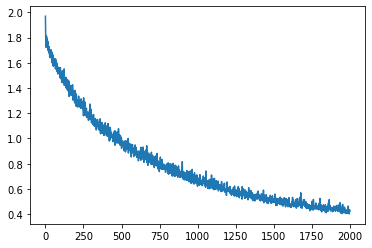

In [21]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])

In [17]:
# Parsimonious approach to evaluation, rather than explicitly calculating all windows
idx_1 = (slice(None), slice(kwargs['patch_size']), slice(kwargs['patch_size']))
idx_2 = (slice(None), slice(-kwargs['patch_size'], None), slice(-kwargs['patch_size'], None))

est_1 = model.predict((x_valid[idx_1] - x_mean)/x_std) * y_std + y_mean
est_2 = model.predict((x_valid[idx_2] - x_mean)/x_std) * y_std + y_mean

In [18]:
rmse = lambda y, z: ((y - z) ** 2).mean() ** 0.5 
rmse1 = ((y_valid[:, -patch_size:, -patch_size:] - est1) ** 2).mean() ** 0.5
rmse2 = ((y_valid[:, :patch_size, :patch_size] - est2) ** 2).mean() ** 0.5
print(f'RMSE start: {rmse(y_valid[idx_1], est_1):.3f}')
print(f'RMSE end:   {rmse(y_valid[idx_2], est_2):.3f}')

RMSE start: 1.337
RMSE end:   0.801
